In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import Enum
import os
import shutil
from tqdm import tqdm
from collections import Counter

# Types of cache
class CacheType(Enum):
    LRU = 1
    RANDOM_EVICTION = 2

# Constants
SEED = 42
DATABASE_OBJECTS = 100 # Number of objects in the database
ACCESS_COUNT_LIMIT = 100   # Total time to run the simulation
EXPERIMENT_BASE_DIR = "./experiments/"
TEMP_BASE_DIR = "./.aoi_cache/"

ZIPF_CONSTANT = 2      # Shape parameter for the Zipf distribution (controls skewness) Needs to be: 1< 

# Set random seeds
random.seed(SEED)
np.random.seed(SEED)

os.makedirs(TEMP_BASE_DIR, exist_ok=True)

How to set certain parameters for specific scenarios


| Name                 | Cache Capacity       | MAX_REFRESH_RATE | cache_type                | CACHE_TTL |
| -------------------- | -------------------- | ---------------- | ------------------------- | --------- |
| Default              | DATABASE_OBJECTS     | 1<               | CacheType.LRU             | 5         |
| No Refresh           | DATABASE_OBJECTS     | 0                | CacheType.LRU             | 5         |
| Infinite TTL         | DATABASE_OBJECTS / 2 | 0                | CacheType.LRU             | 0         |
| Random Eviction (RE) | DATABASE_OBJECTS / 2 | 1<               | CacheType.RANDOM_EVICTION | 5         |
| RE without Refresh   | DATABASE_OBJECTS / 2 | 0                | CacheType.RANDOM_EVICTION | 5         |




In [2]:
# Configuration (Just example, will be overwritten in next block

CACHE_CAPACITY = DATABASE_OBJECTS   # Maximum number of objects the cache can hold

# MAX_REFRESH_RATE is used as the maximum for a uniform
# distribution for mu.
# If MAX_REFRESH_RATE is 0, we do not do any refreshes.
MAX_REFRESH_RATE = 0

cache_type = CacheType.LRU

# CACHE_TTL is used to determin which TTL to set when an
# object is pulled into the cache
# If CACHE_TTL is set to 0, the TTL is infinite
CACHE_TTL = 5


In [3]:
class Database:
    def __init__(self):
        # Each object now has a specific refresh rate 'mu'
        self.data = {i: f"Object {i}" for i in range(1, DATABASE_OBJECTS + 1)}
        self.lambda_values = {i: np.random.zipf(ZIPF_CONSTANT) for i in range(1, DATABASE_OBJECTS + 1)}  # Request rate 'lambda' for each object
        # Refresh rate 'mu' for each object
        if MAX_REFRESH_RATE == 0:
            self.mu_values = {i: 0 for i in range(1,DATABASE_OBJECTS + 1)}    
        else:
            self.mu_values = {i: np.random.uniform(1, MAX_REFRESH_RATE) for i in range(1, DATABASE_OBJECTS + 1)}
        self.next_request = {i: np.random.exponential(1/self.lambda_values[i]) for i in range(1, DATABASE_OBJECTS + 1)}


    def get_object(self, obj_id):
        # print(f"[{env.now:.2f}] Database: Fetched {self.data.get(obj_id, 'Unknown')} for ID {obj_id}")
        return self.data.get(obj_id, None)

In [4]:
class Cache:
    def __init__(self, env, db, cache_type):
        self.cache_type = cache_type
        self.env = env
        self.db = db
        self.storage = {}  # Dictionary to store cached objects
        self.ttl = {}      # Dictionary to store TTLs
        self.age = {}      # Dictionary to store age of each object
        self.cache_size_over_time = []  # To record cache state at each interval
        self.cache_next_request_over_time = []
        self.request_log = {i: [] for i in range(1, DATABASE_OBJECTS + 1)}
        self.hits = {i: 0 for i in range(1, DATABASE_OBJECTS + 1)}  # Track hits per object
        self.misses = {i: 0 for i in range(1, DATABASE_OBJECTS + 1)}  # Track misses per object
        self.cumulative_age = {i: 0 for i in range(1, DATABASE_OBJECTS + 1)}  # Track cumulative age per object
        self.access_count = {i: 0 for i in range(1, DATABASE_OBJECTS + 1)}  # Track access count per object
        self.next_refresh = {}  # Track the next refresh time for each cached object
        
    def get(self, obj_id):
        if obj_id in self.storage and \
        (self.ttl[obj_id] > env.now or CACHE_TTL == 0):
            # Cache hit: increment hit count and update cumulative age
            self.hits[obj_id] += 1
            self.cumulative_age[obj_id] += self.age[obj_id]
            self.access_count[obj_id] += 1
        else:
            # Cache miss: increment miss count
            self.misses[obj_id] += 1
            self.cumulative_age[obj_id] += 0
            self.access_count[obj_id] += 1
            
            # Fetch the object from the database if it’s not in cache
            obj = self.db.get_object(obj_id)
            
            # If the cache is full, evict the oldest object
            if len(self.storage) > CACHE_CAPACITY:
                if self.cache_type == CacheType.LRU:
                    self.evict_oldest()
                elif self.cache_type == CacheType.RANDOM_EVICTION:
                    self.evict_random()
            
            # Add the object to cache, set TTL, reset age, and schedule next refresh
            self.storage[obj_id] = obj
            if CACHE_TTL != 0:
                self.ttl[obj_id] = env.now + CACHE_TTL
            else:
                self.ttl[obj_id] = 0
            self.age[obj_id] = 0
            if MAX_REFRESH_RATE != 0:
                self.next_refresh[obj_id] = env.now + np.random.exponential(1/self.db.mu_values[obj_id])  # Schedule refresh

        
    def evict_oldest(self):
        """Remove the oldest item from the cache to make space."""
        oldest_id = max(self.age, key=self.age.get)  # Find the oldest item by age
        print(f"[{env.now:.2f}] Cache: Evicting oldest object {oldest_id} to make space at {self.ttl[oldest_id]:.2f}")
        del self.storage[oldest_id]
        del self.ttl[oldest_id]
        del self.age[oldest_id]

    def evict_random(self):
        """Remove a random item from the cache to make space."""
        random_id = np.random.choice(list(self.storage.keys()))  # Select a random key from the cache
        print(f"[{env.now:.2f}] Cache: Evicting random object {random_id} to make space at {self.ttl[random_id]:.2f}")
        del self.storage[random_id]
        del self.ttl[random_id]
        del self.age[random_id]
        
    def refresh_object(self, obj_id):
        """Refresh the object from the database to keep it up-to-date. TTL is increased on refresh."""
        obj = self.db.get_object(obj_id)
        self.storage[obj_id] = obj
        if CACHE_TTL != 0:
            self.ttl[obj_id] = env.now + CACHE_TTL
        else:
            self.ttl[obj_id] = 0
        self.age[obj_id] = 0
        # print(f"[{env.now:.2f}] Cache: Refreshed object {obj_id}")
        
    def age_objects(self):
        """Increment age of each cached object."""
        for obj_id in list(self.age.keys()):
            if CACHE_TTL != 0:
                if self.ttl[obj_id] > env.now:
                    self.age[obj_id] += 1
                    # print(f"[{env.now:.2f}] Cache: Object {obj_id} aged to {self.age[obj_id]}")
                else:
                        # Remove object if its TTL expired
                        # print(f"[{env.now:.2f}] Cache: Object {obj_id} expired")
                        del self.storage[obj_id]
                        del self.ttl[obj_id]
                        del self.age[obj_id]
            else:
                self.age[obj_id] += 1
                
    def record_cache_state(self):
        """Record the current cache state (number of objects in cache) over time."""
        self.cache_size_over_time.append((env.now, len(self.storage)))
        self.cache_next_request_over_time.append((env.now, self.db.next_request.copy()))

In [5]:
def age_cache_process(env, cache):
    """Process that ages cache objects over time, removes expired items, and refreshes based on object-specific intervals."""
    while True:
        cache.age_objects()  # Age objects and remove expired ones


        if MAX_REFRESH_RATE != 0:
            # Refresh objects based on their individual refresh intervals
            for obj_id in list(cache.storage.keys()):
                # Check if it's time to refresh this object based on next_refresh
                if env.now >= cache.next_refresh[obj_id]:
                    cache.refresh_object(obj_id)
                    # Schedule the next refresh based on the object's mu
                    cache.next_refresh[obj_id] = env.now + np.random.exponential(1/cache.db.mu_values[obj_id])
        
        cache.record_cache_state()  # Record cache state at each time step
        yield env.timeout(1)  # Run every second


In [6]:
def client_request_process(env, cache, event):
    """Client process that makes requests for objects from the cache."""
    last_print = 0
    with tqdm(total=ACCESS_COUNT_LIMIT, desc="Progress", leave=True) as pbar:
        while True:
            obj_id, next_request = min(cache.db.next_request.items(), key=lambda x: x[1])
            yield env.timeout(next_request - env.now)
            if (int(env.now) % 1) == 0 and int(env.now) != last_print:
                last_print = int(env.now)
                pbar.n = min(cache.access_count.values())
                pbar.refresh()
            if env.now >= next_request:
                # print(f"[{env.now:.2f}] Client: Requesting object {obj_id}")
                cache.get(obj_id)
                
                # print(f"[{env.now:.2f}] Client: Schedule next request for {obj_id}")
                next_request = env.now + np.random.exponential(1/cache.db.lambda_values[obj_id])
                cache.request_log[obj_id].append(next_request)
                cache.db.next_request[obj_id] = next_request
            if all(access_count >= ACCESS_COUNT_LIMIT for access_count in cache.access_count.values()):
                event.succeed()

In [7]:
configurations = {
    "default": (DATABASE_OBJECTS, 10, CacheType.LRU, 5),
    "No Refresh": (DATABASE_OBJECTS, 0, CacheType.LRU, 5),
    "Infinite TTL": (int(DATABASE_OBJECTS / 2), 0, CacheType.LRU, 0),
    "Random Eviction": (int(DATABASE_OBJECTS / 2), 10, CacheType.RANDOM_EVICTION, 5),
    "RE without Refresh": (int(DATABASE_OBJECTS / 2), 0, CacheType.RANDOM_EVICTION, 5),
    "No Refresh (0.5s ttl)": (DATABASE_OBJECTS, 0, CacheType.LRU, 0.5),
    "No Refresh (1.0s ttl)": (DATABASE_OBJECTS, 0, CacheType.LRU, 1),
    "No Refresh (2.0s ttl)": (DATABASE_OBJECTS, 0, CacheType.LRU, 2),
    "No Refresh (3.0s ttl)": (DATABASE_OBJECTS, 0, CacheType.LRU, 3),
    "No Refresh (4.0s ttl)": (DATABASE_OBJECTS, 0, CacheType.LRU, 4),
    "No Refresh (5.0s ttl)": (DATABASE_OBJECTS, 0, CacheType.LRU, 5),
}
experiments = configurations.keys()


In [8]:
experiments = [e for e in experiments if "ttl)" in e]
experiments

['No Refresh (0.5s ttl)',
 'No Refresh (1.0s ttl)',
 'No Refresh (2.0s ttl)',
 'No Refresh (3.0s ttl)',
 'No Refresh (4.0s ttl)',
 'No Refresh (5.0s ttl)']

Progress:  99%|███████████████████████████████████████████████████████▍| 99/100 [00:01<00:00, 74.80it/s]

Progress:   0%|                                                                 | 0/100 [00:00<?, ?it/s]

Progress:   0%|                                                                 | 0/100 [00:00<?, ?it/s]

Progress:   0%|                                                                 | 0/100 [00:00<?, ?it/s]

Progress:   0%|                                                                 | 0/100 [00:00<?, ?it/s]

Progress:   1%|▌                                                        | 1/100 [00:00<00:05, 18.13it/s]

Progress:   1%|▌                                                        | 1/100 [00:00<00:07, 14.01it/s]

Progress:   2%|█▏                                                       | 2/100 [00:00<00:04, 23.74it/s]

Progress:   2%|█▏                                                       | 2/100 [00:00<00:04, 20.84it/s]

Progress:   2%|█▏                             

CPU times: user 9.09 s, sys: 3.93 s, total: 13 s
Wall time: 9.48 s


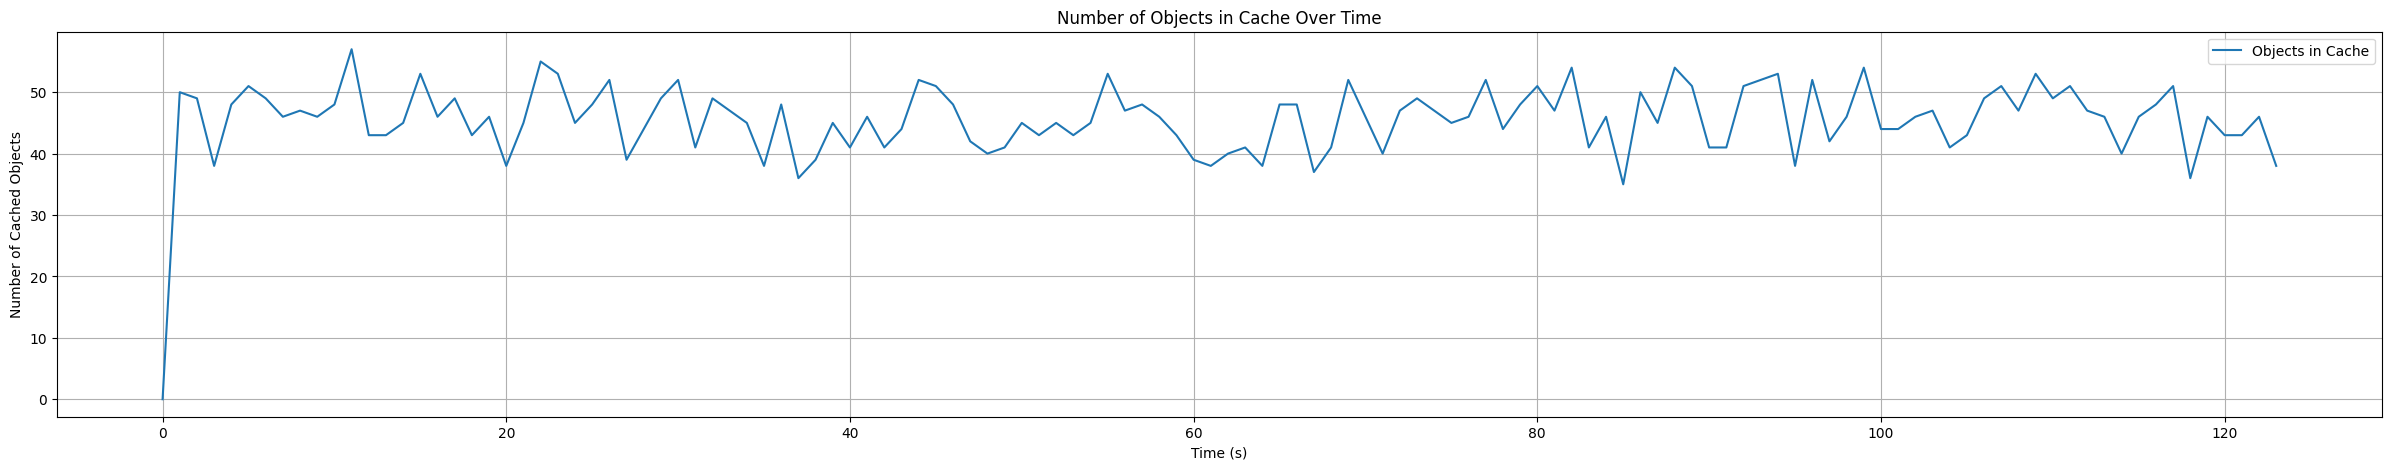

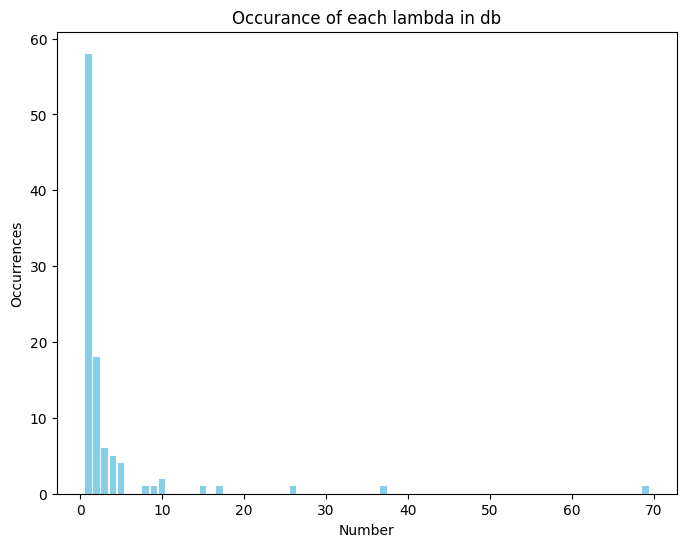

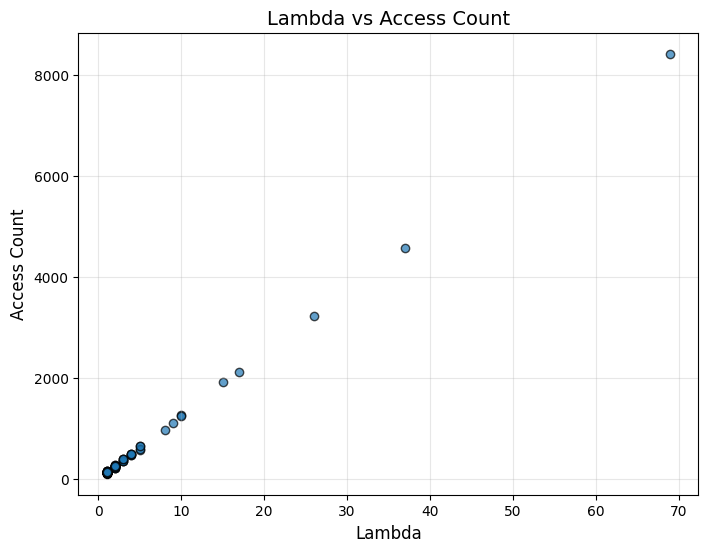

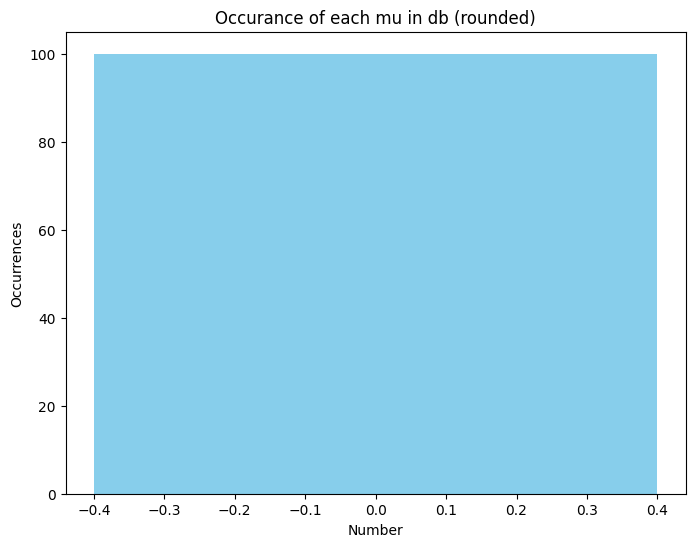

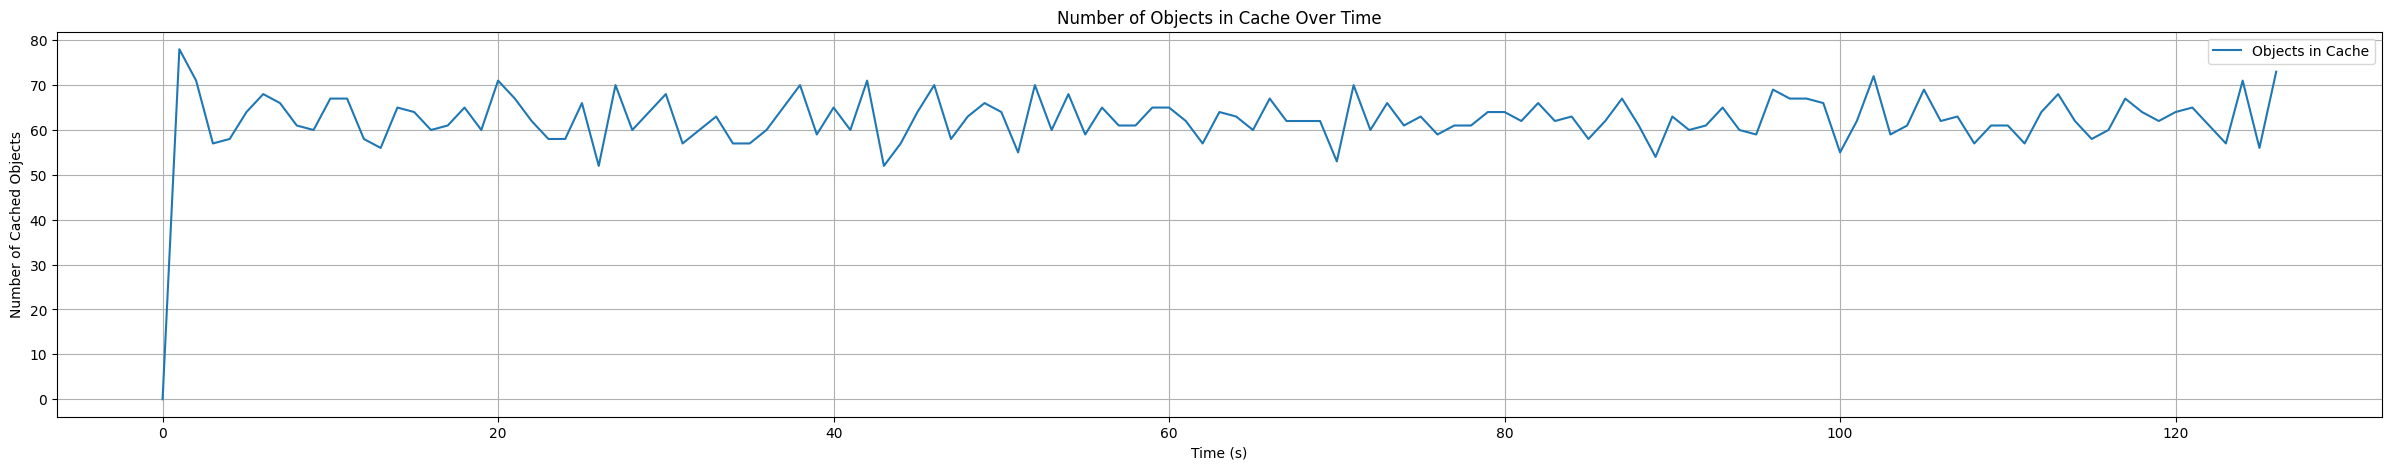

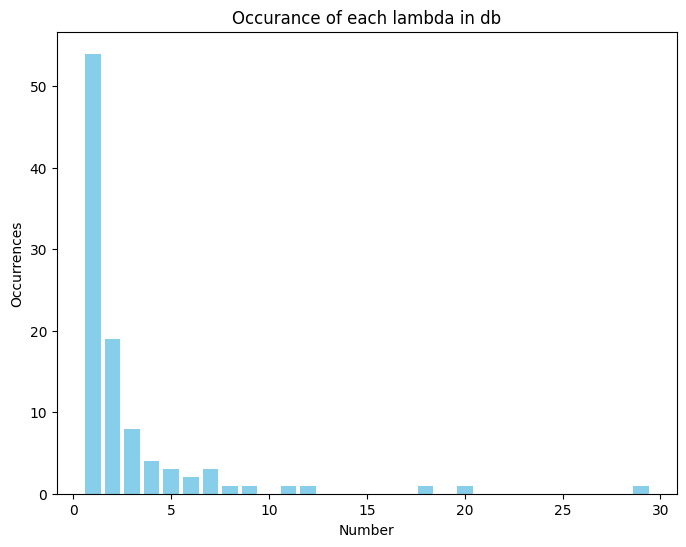

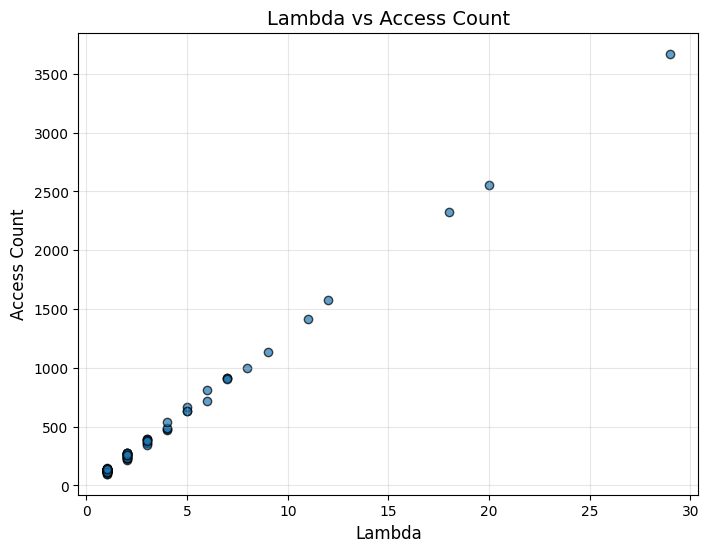

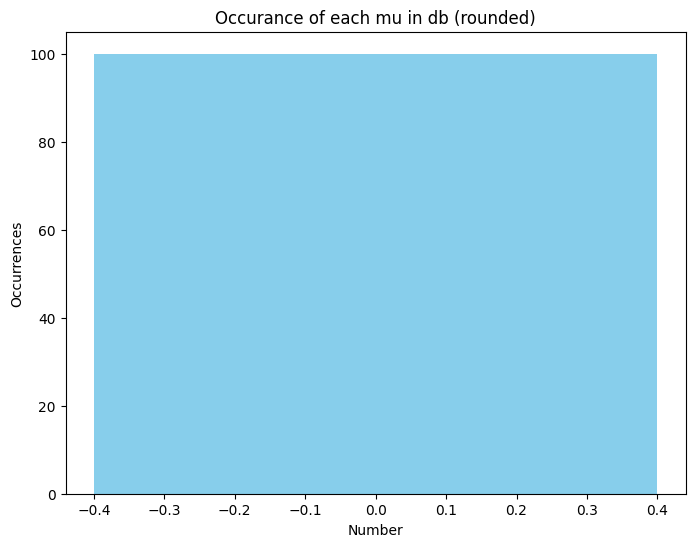

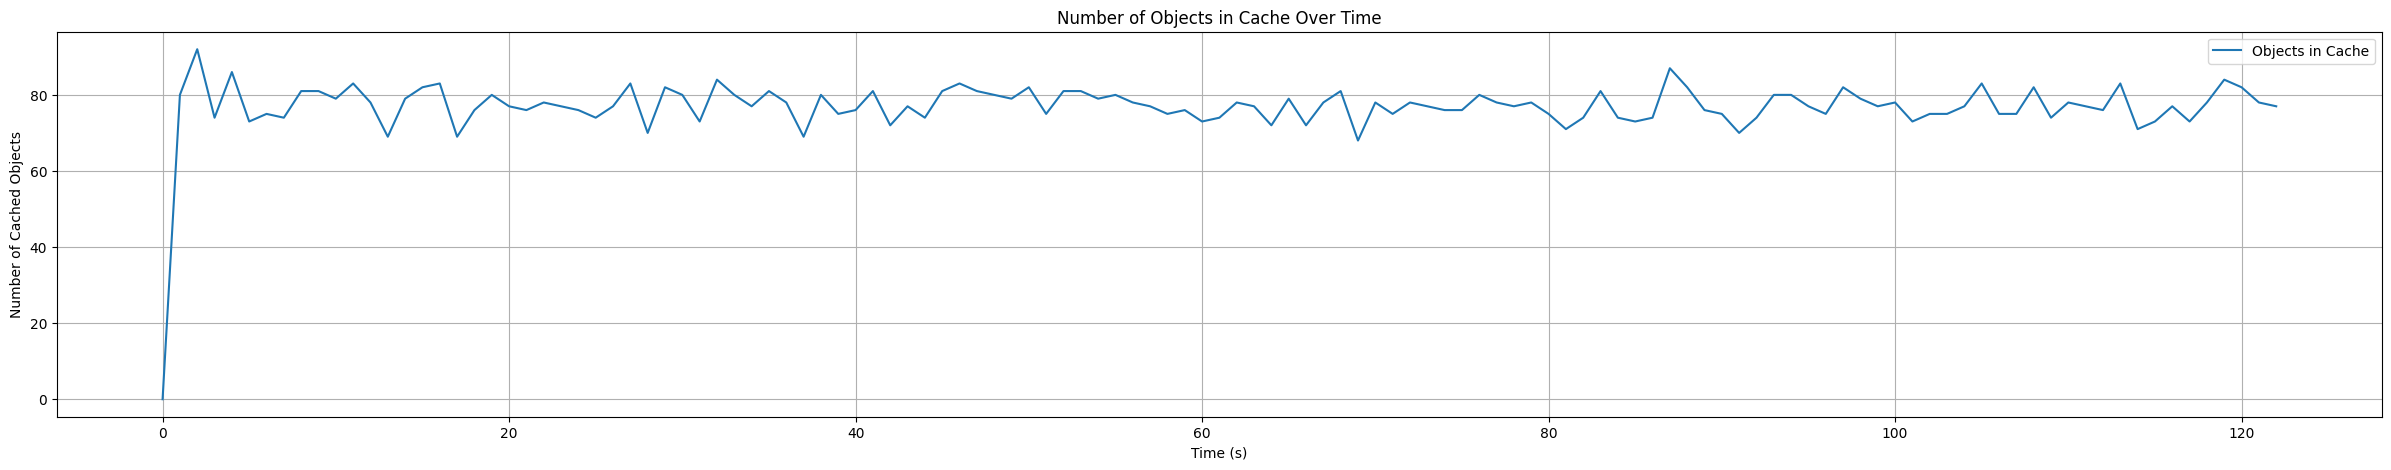

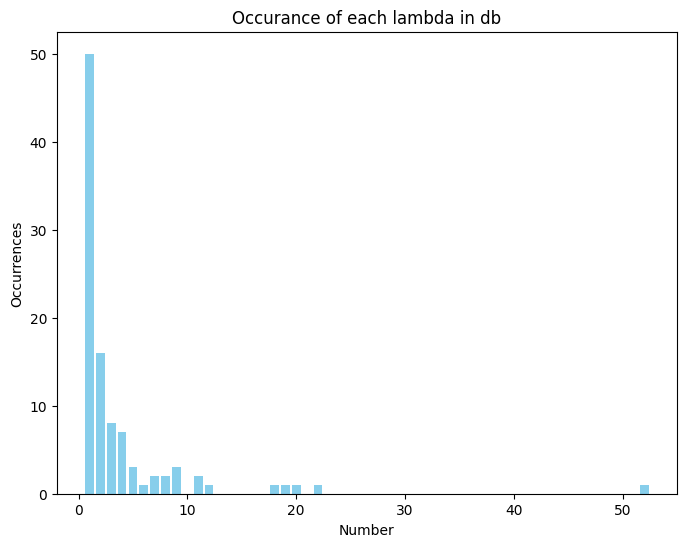

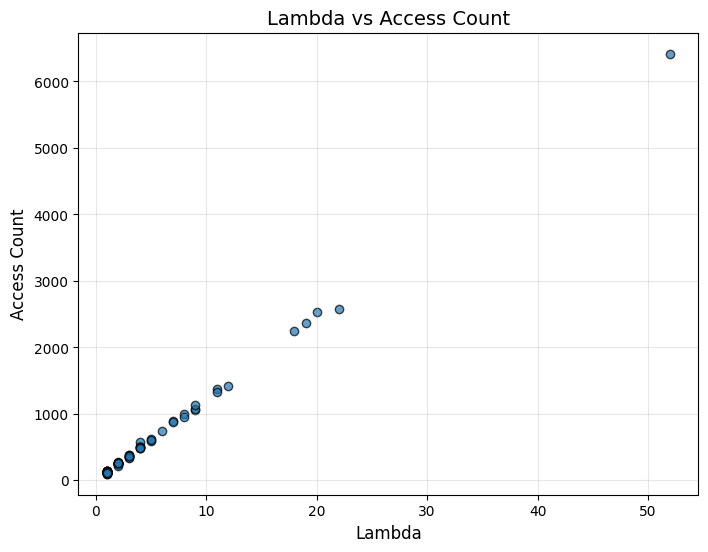

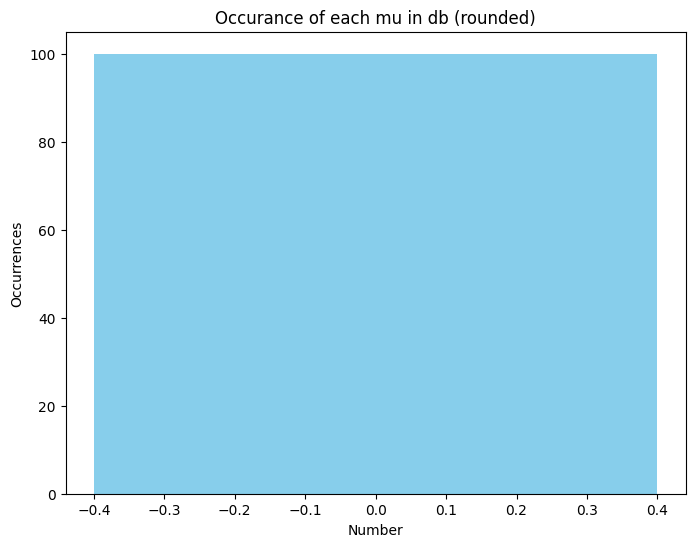

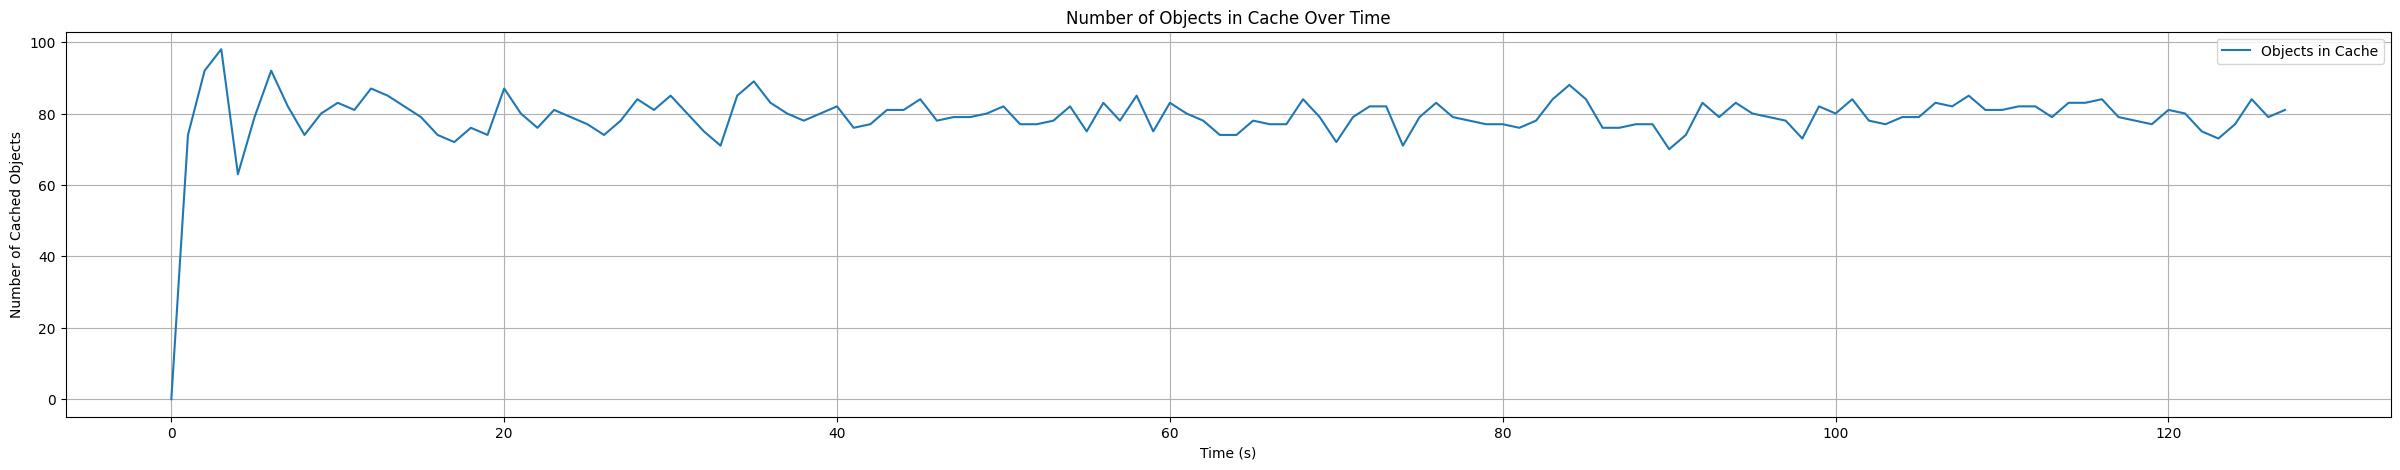

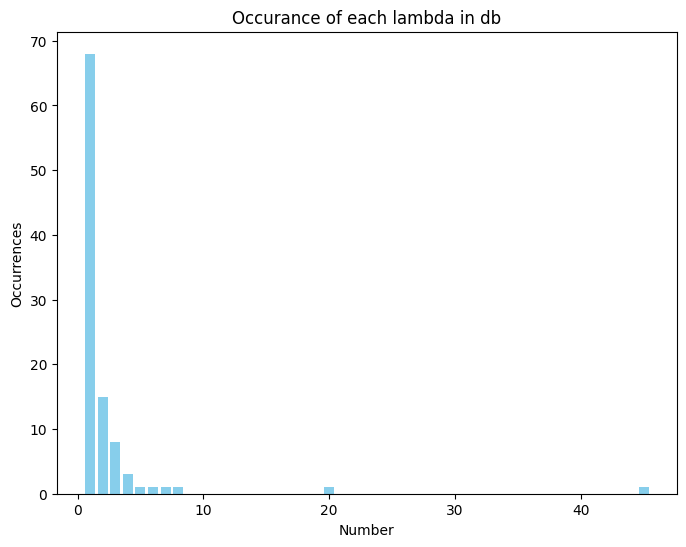

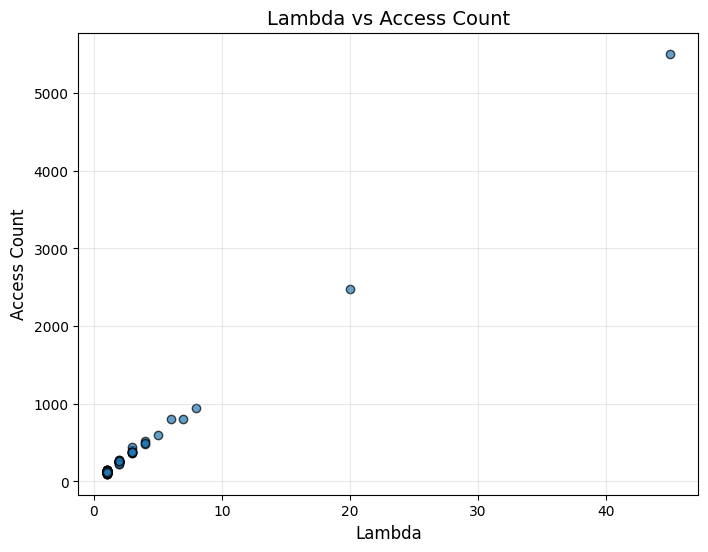

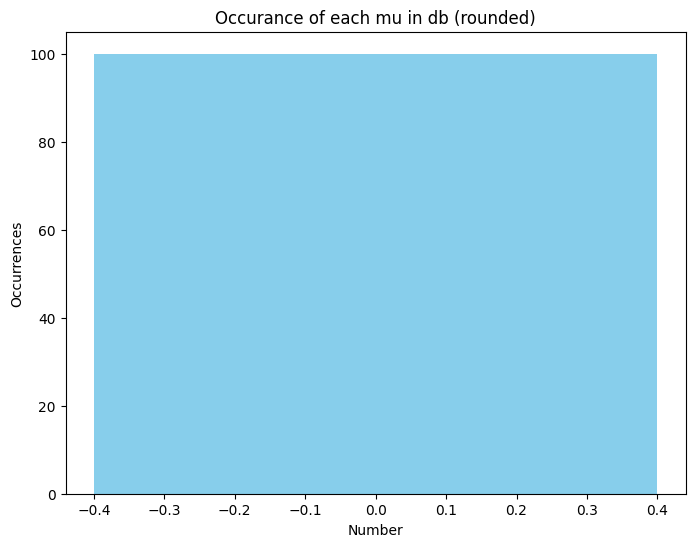

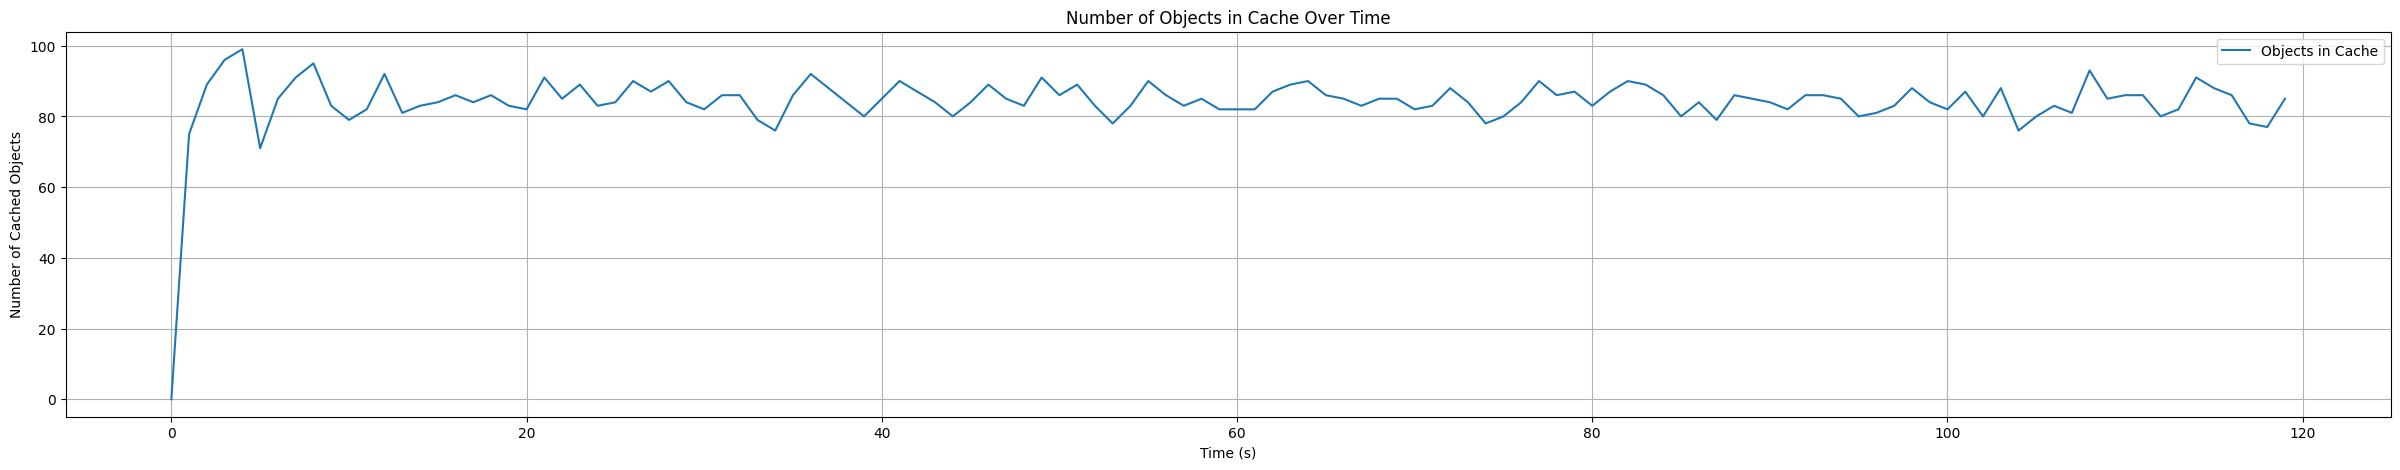

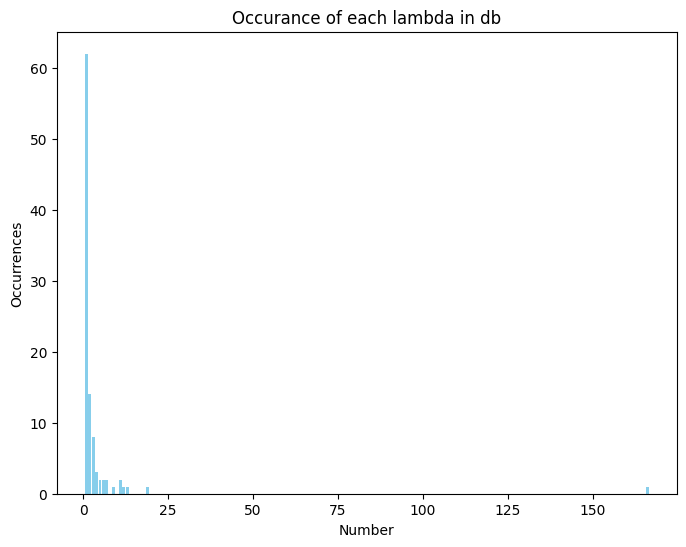

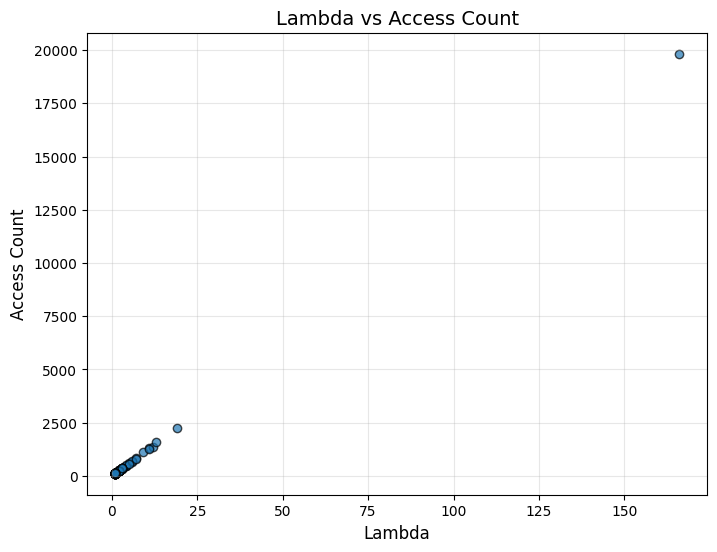

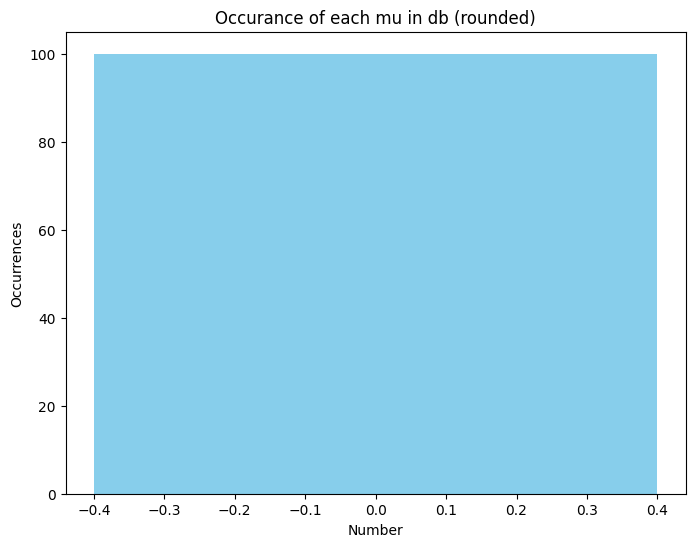

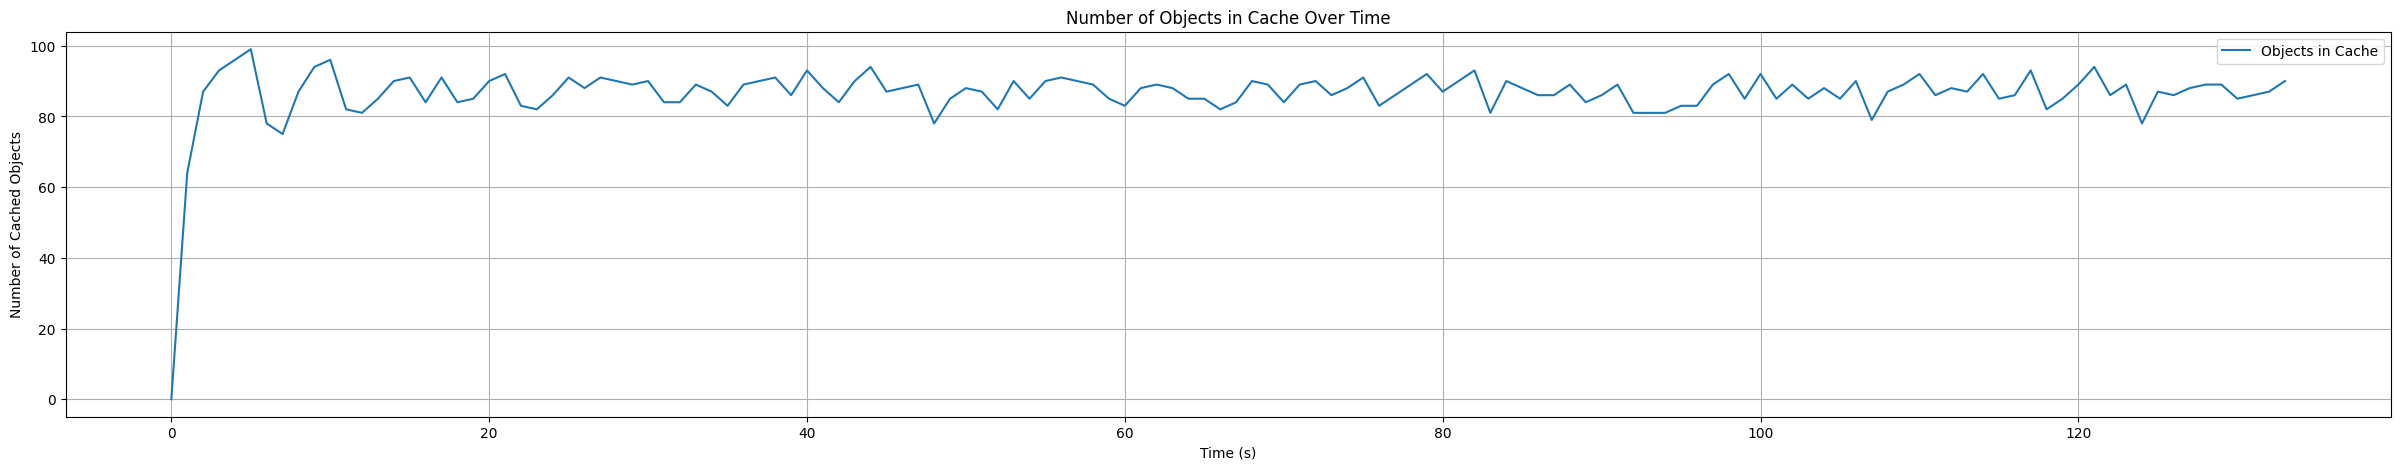

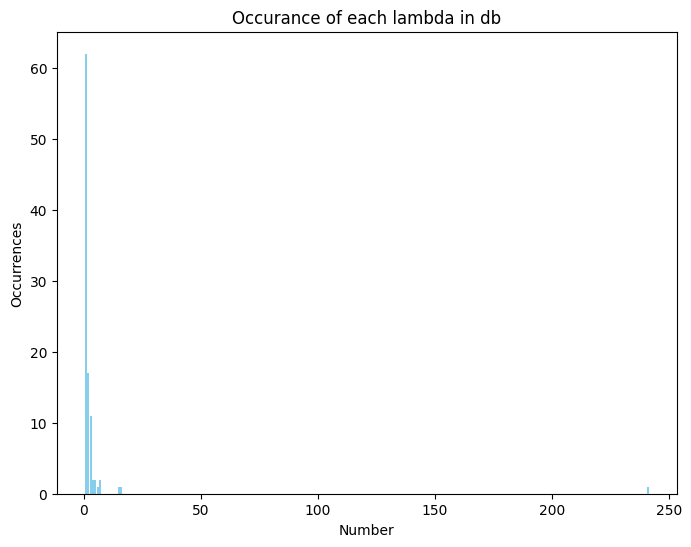

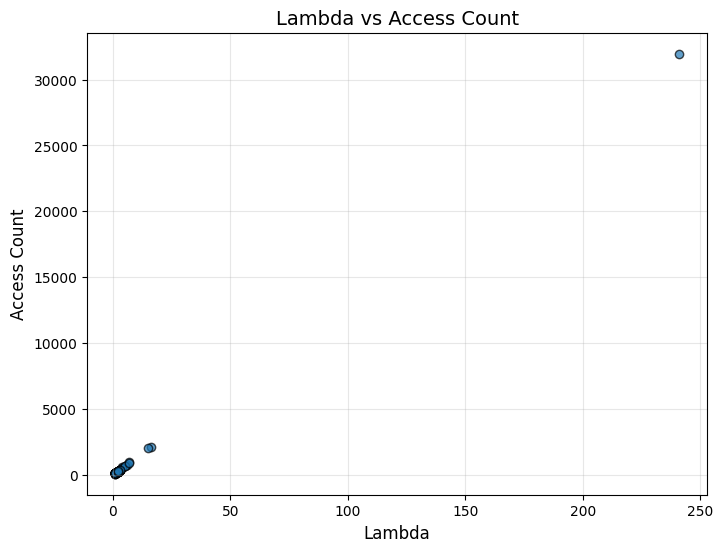

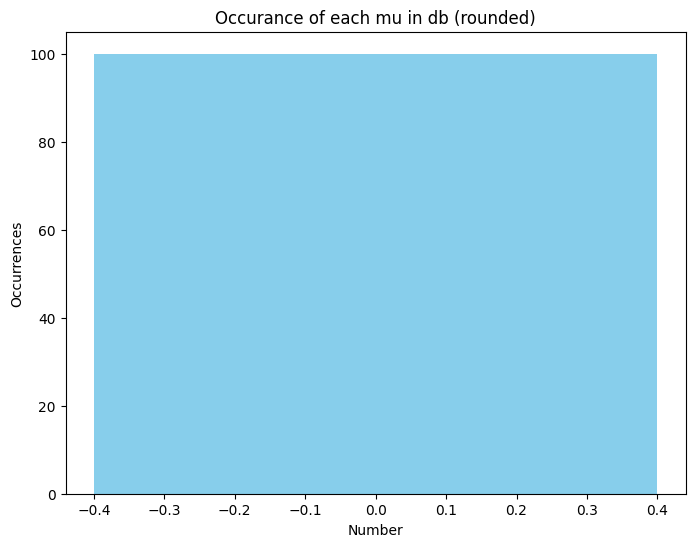

In [9]:
%%time
for experiment_name in experiments:
    config = configurations[experiment_name]

    CACHE_CAPACITY = config[0]
    MAX_REFRESH_RATE = config[1]
    cache_type = config[2]
    CACHE_TTL = config[3]

    # Initialize simulation environment
    env = simpy.Environment()

    # Instantiate components
    db = Database()
    cache = Cache(env, db, cache_type)
    stop_event = env.event()

    # Start processes
    env.process(age_cache_process(env, cache))
    env.process(client_request_process(env, cache, stop_event))

    # Run the simulation
    env.run(until=stop_event)

    statistics = []
    # Calculate and print hit rate and average age for each object
    for obj_id in range(1, DATABASE_OBJECTS + 1):
        if cache.access_count[obj_id] != 0:
            hit_rate = cache.hits[obj_id] / max(1, cache.access_count[obj_id])  # Avoid division by zero
            avg_age = cache.cumulative_age[obj_id] / max(1, cache.access_count[obj_id])  # Average over access_count
            statistics.append({"obj_id": obj_id,"hit_rate": hit_rate,"avg_age": avg_age})

    stats = pd.DataFrame(statistics)
    stats.to_csv(f"{TEMP_BASE_DIR}/hit_age.csv",index=False)
    stats.drop("obj_id", axis=1).describe().to_csv(f"{TEMP_BASE_DIR}/overall_hit_age.csv")

    avg_age = {
        obj_id: cache.cumulative_age[obj_id] / max(1, cache.access_count[obj_id]) 
        for obj_id in range(1, DATABASE_OBJECTS + 1)
    }

    hit_rate = {
        obj_id: np.round((cache.hits[obj_id] / max(1, cache.access_count[obj_id]))*100,2) 
        for obj_id in range(1, DATABASE_OBJECTS + 1)
    }
    
    access_count = pd.DataFrame.from_dict(cache.access_count, orient='index', columns=['access_count'])
    hits = pd.DataFrame.from_dict(cache.hits, orient='index', columns=['hits'])
    misses = pd.DataFrame.from_dict(cache.misses, orient='index', columns=['misses'])
    mu = pd.DataFrame.from_dict(db.mu_values, orient='index', columns=['mu'])
    lmbda = pd.DataFrame.from_dict(db.lambda_values, orient='index', columns=['lambda'])
    hit_rate = pd.DataFrame.from_dict(hit_rate, orient='index', columns=['hit_rate'])
    avg_age = pd.DataFrame.from_dict(avg_age, orient='index', columns=['avg_age'])
    
    merged = access_count.merge(hits, left_index=True, right_index=True).merge(misses, left_index=True, right_index=True)\
        .merge(mu, left_index=True, right_index=True).merge(lmbda, left_index=True, right_index=True)\
        .merge(hit_rate, left_index=True, right_index=True).merge(avg_age, left_index=True, right_index=True)
    merged.to_csv(f"{TEMP_BASE_DIR}/details.csv", index_label="obj_id")

    # Extract recorded data for plotting
    times, cache_sizes = zip(*cache.cache_size_over_time)

    # Plot the cache size over time
    plt.figure(figsize=(30, 5))
    plt.plot(times, cache_sizes, label="Objects in Cache")
    plt.xlabel("Time (s)")
    plt.ylabel("Number of Cached Objects")
    plt.title("Number of Objects in Cache Over Time")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{TEMP_BASE_DIR}/objects_in_cache_over_time.pdf")

    # Count occurrences of each number
    count = Counter(list(db.lambda_values.values()))

    # Separate the counts into two lists for plotting
    x = list(count.keys())  # List of unique numbers
    y = list(count.values())  # List of their respective counts

    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.bar(x, y, color='skyblue')

    # Adding labels and title
    plt.xlabel('Number')
    plt.ylabel('Occurrences')
    plt.title('Occurance of each lambda in db')
    plt.savefig(f"{TEMP_BASE_DIR}/lambda_distribution.pdf")

    # Plotting lambda against access_count.
    plt.figure(figsize=(8, 6))
    plt.scatter(merged['lambda'], merged['access_count'], alpha=0.7, edgecolor='k')
    plt.title('Lambda vs Access Count', fontsize=14)
    plt.xlabel('Lambda', fontsize=12)
    plt.ylabel('Access Count', fontsize=12)
    plt.grid(alpha=0.3)

    plt.savefig(f"{TEMP_BASE_DIR}/lambda_vs_access_count.pdf")
    
    # Count occurrences of each number
    count = Counter(np.array(list(db.mu_values.values())).round(0))

    # Separate the counts into two lists for plotting
    x = list(count.keys())  # List of unique numbers
    y = list(count.values())  # List of their respective counts

    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.bar(x, y, color='skyblue')

    # Adding labels and title
    plt.xlabel('Number')
    plt.ylabel('Occurrences')
    plt.title('Occurance of each mu in db (rounded)')

    os.makedirs(EXPERIMENT_BASE_DIR, exist_ok=True)
    folder_name = experiment_name.replace(" ", "_").replace("(", "").replace(")", "").replace(".", "_")
    folder_path = os.path.join(EXPERIMENT_BASE_DIR, folder_name)
    os.makedirs(folder_path, exist_ok=True)

    file_names = os.listdir(TEMP_BASE_DIR)

    for file_name in file_names:
        shutil.move(os.path.join(TEMP_BASE_DIR, file_name), folder_path)

    del env
    del cache
    del db